In [1]:
#Unsupervised :D
import os 
import pandas as pd 
import numpy as np

In [2]:
#1. Load Dataset: 

def import_(N): 
    data_lst = []
    for i in range(N): 
        data = None
        data = pd.read_csv(os.getcwd()+'/bike_0'+str(i+1)+'.csv')
        data_lst.append(data)
        
    return data_lst
        
    
#Concat the sets 
def concat(lst_of_DFs): 
    df = pd.concat(lst_of_DFs)
    return df

In [3]:
#2. CLEAN/SELECTION/BINNING/STANDARDIZE
from sklearn.preprocessing import StandardScaler as SS
from scipy import stats

def cleaned_df(standardize=True): 
    
    df = concat(import_(5))

    #convert to numeric
    df['user_type'] = np.where(df['user_type']=='Subscriber',1,0) 
    df['member_gender'] = np.where(df['member_gender']=='Male',1,0)
    df['member_age'] = 2019-df['member_birth_year'] 

    #drop_columns
    col_drop = ['start_station_name','end_station_name', 'month','bike_id',
                'member_birth_year','end_station_id','start_station_id'] 
    df.drop(col_drop, inplace=True, axis=1)
    
    #drop nulls
    df.dropna(inplace=True) 
    
    #remove outliers
    df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)] 
    
    if standardize:
        fit = SS().fit(np.array(df))
        trans = fit.transform(np.array(df))

        df_ = pd.DataFrame(trans)
        df_.columns = df.columns

    
    return df_
    

In [4]:
df = cleaned_df()
print(df.shape)
df.head()

(990094, 4)


,trip_duration_sec,user_type,member_gender,member_age
0,0.959234,0.356275,0.589978,0.108382
1,1.081545,0.356275,0.589978,-0.637007
2,4.600754,0.356275,0.589978,0.640804
3,-0.643776,0.356275,0.589978,-0.637007
4,-0.439925,0.356275,0.589978,-1.169428


In [5]:
#3. Descriptives

In [6]:
def Descriptives(dataframe):
    # get the data type
    print(type(dataframe))
    print("amount of entries is %s" % dataframe.size)
    print("dimensions= %i" % dataframe.ndim)
    print("shape is ", end="")
    print(dataframe.shape)
    print("axes: ", end="")
    print(dataframe.axes)
    print("data types of columns:")
    print(dataframe.dtypes)
    print("features: %s" % dataframe.columns)
    print("\n Missing Values: ")
    print(dataframe.isnull().sum())

In [7]:
Descriptives(df)

<class 'pandas.core.frame.DataFrame'>
amount of entries is 3960376
dimensions= 2
shape is (990094, 4)
axes: [RangeIndex(start=0, stop=990094, step=1), Index(['trip_duration_sec', 'user_type', 'member_gender', 'member_age'], dtype='object')]
data types of columns:
trip_duration_sec    float64
user_type            float64
member_gender        float64
member_age           float64
dtype: object
features: Index(['trip_duration_sec', 'user_type', 'member_gender', 'member_age'], dtype='object')

 Missing Values: 
trip_duration_sec    0
user_type            0
member_gender        0
member_age           0
dtype: int64


In [8]:
#4. CREATE MODEL(s)

#Model is so computationally heavy we need to apply PCA and cut to a random sample
from sklearn.decomposition import PCA

def Sample_PCA(size,dims=0):
    sample = df.sample(size) #grab sample
    df_pca = sample
    if dims >0:
        pca = PCA(n_components=dims) 
        pca.fit(sample)
        df_pca = pd.DataFrame(pca.transform(sample))
        
    return df_pca, sample

In [9]:
sample_pca, sample = Sample_PCA(2500,2) 
#after many trials, dimention reduction down to 2-D gives best cluster seperations

In [10]:
#Create and fit model, also spits out some elbow cure evaluations to check best k and model
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering as AC
from yellowbrick.cluster import KElbowVisualizer

def model_(tipe,k,elbow=False):
        
    if tipe=='KMEANS': 
        model = KMeans(n_clusters=k)
        model.fit(sample_pca)
        labels = model.labels_
        
    elif tipe=='AC':
        model = AC(n_clusters=k)
        model.fit(sample_pca)
        labels = model.labels_
        
    
    sample['cluster'] = labels    
    
    if elbow:
        visualizer = KElbowVisualizer(model, k=(2,10),metric='silhouette')
        visualizer.fit(sample_pca)
        visualizer.poof()
        visualizer = KElbowVisualizer(model, k=(2,10),metric='distortion')
        visualizer.fit(sample_pca)
        visualizer.poof()

    return sample_pca, sample.cluster
    

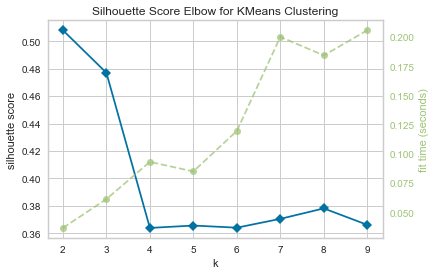

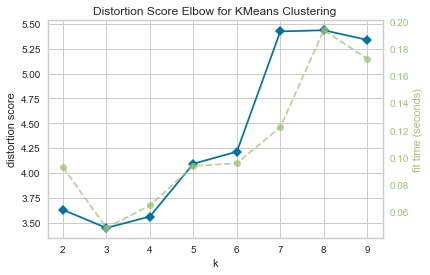

(             0         1
 0     0.562515 -0.613642
 1     0.318161 -0.449620
 2    -0.487581 -0.452863
 3     1.473231  1.673403
 4    -0.135653 -0.864619
 5    -0.032364  0.074707
 6    -0.226339 -1.350716
 7     3.813159  0.816290
 8     0.545746 -0.284759
 9     0.247547 -0.255385
 10   -0.778583  2.336134
 11    1.243604  0.456933
 12   -0.306448  0.407252
 13   -0.499710 -0.681930
 14    0.143633  0.708698
 15   -0.071352  1.919043
 16   -0.660900  1.825771
 17   -0.927776  1.713427
 18    1.409441  0.588289
 19   -0.620177  0.163204
 20   -0.433973 -0.430296
 21    0.255325 -0.518995
 22    0.333666  0.185867
 23   -0.213238 -0.113414
 24   -0.260234 -0.400082
 25   -0.412090 -1.092968
 26    0.844253  0.555707
 27   -0.030055 -0.484224
 28    3.098770  0.515562
 29   -0.643226  0.825385
 ...        ...       ...
 2470 -0.122293  1.044676
 2471 -1.165992  1.389187
 2472  0.534070 -0.849577
 2473  0.759588 -0.935682
 2474  0.574406 -0.496655
 2475 -0.548259  1.046401
 2476  0.360

In [11]:
#5. Hyperparameter Tuning
model_('KMEANS',2,elbow=True) #metrics show optimal k at k=2 for KMEANS model

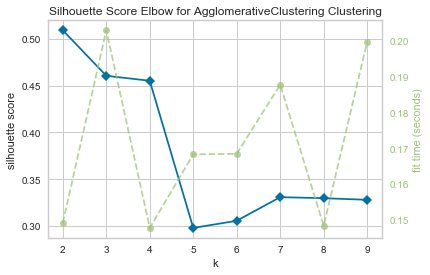

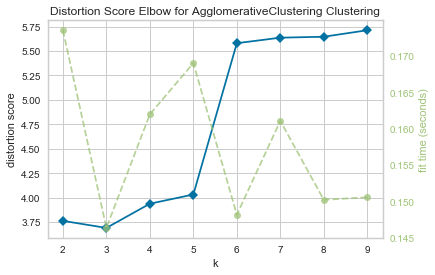

(             0         1
 0     0.562515 -0.613642
 1     0.318161 -0.449620
 2    -0.487581 -0.452863
 3     1.473231  1.673403
 4    -0.135653 -0.864619
 5    -0.032364  0.074707
 6    -0.226339 -1.350716
 7     3.813159  0.816290
 8     0.545746 -0.284759
 9     0.247547 -0.255385
 10   -0.778583  2.336134
 11    1.243604  0.456933
 12   -0.306448  0.407252
 13   -0.499710 -0.681930
 14    0.143633  0.708698
 15   -0.071352  1.919043
 16   -0.660900  1.825771
 17   -0.927776  1.713427
 18    1.409441  0.588289
 19   -0.620177  0.163204
 20   -0.433973 -0.430296
 21    0.255325 -0.518995
 22    0.333666  0.185867
 23   -0.213238 -0.113414
 24   -0.260234 -0.400082
 25   -0.412090 -1.092968
 26    0.844253  0.555707
 27   -0.030055 -0.484224
 28    3.098770  0.515562
 29   -0.643226  0.825385
 ...        ...       ...
 2470 -0.122293  1.044676
 2471 -1.165992  1.389187
 2472  0.534070 -0.849577
 2473  0.759588 -0.935682
 2474  0.574406 -0.496655
 2475 -0.548259  1.046401
 2476  0.360

In [12]:
model_('AC',2,elbow=True) #metrics show optimal k at k=2 for AC model

In [13]:
#Plot clusters along all dimesions
import matplotlib.pyplot as plt
from itertools import combinations 

def plot_(df,clusters):
    comb = combinations(sample_pca.columns, 2)
    for a,b in comb:
        plt.subplots(1, 1)
        plt.scatter(df[a], df[b], c=clusters, cmap='plasma')
        plt.ylabel(b)
        plt.xlabel(a)
        
    
    

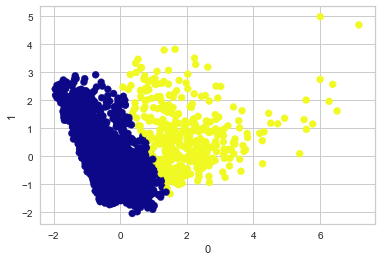

In [14]:
df_km, clusters_km = model_('KMEANS',2) #KMEANS model
plot_(df_km, clusters_km)

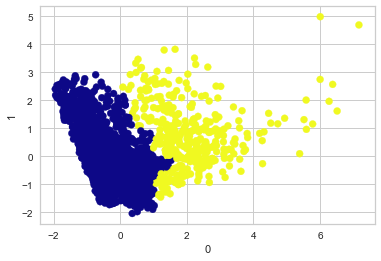

In [15]:
df_ac, clusters_ac = model_('AC',2) #AC model
plot_(df_ac, clusters_ac)

In [22]:
#TSNE is also used as a clustering evaluation metric

from sklearn.manifold import TSNE

def Tsne(df,clusters):

    fig, ax = plt.subplots(1, 3, figsize=(15, 7))
    for i, perp in enumerate([10,20,30]):
        tsne = TSNE(perplexity=perp)
        x_embedded = tsne.fit_transform(df)
        ax[i].scatter(x_embedded[:, 0], x_embedded[:, 1], c=clusters, cmap='plasma')
        ax[i].set_title("Perplexity = {}".format(perp))

    plt.show()

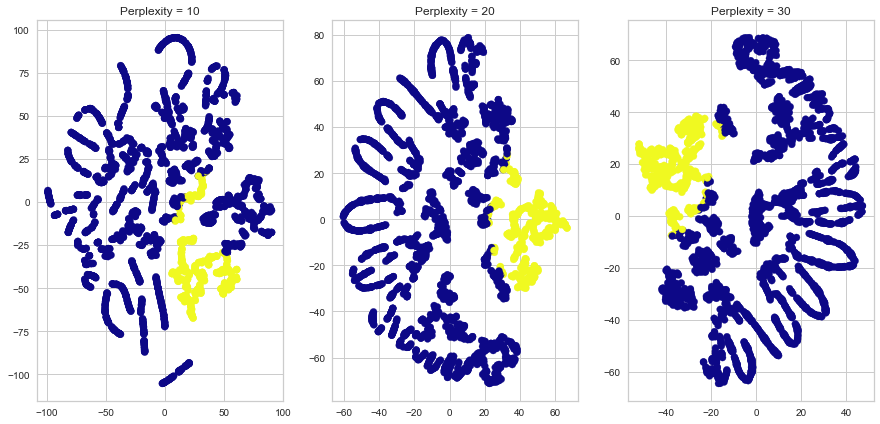

In [23]:
Tsne(df_km,clusters_km) #TSNE on KMEANS model

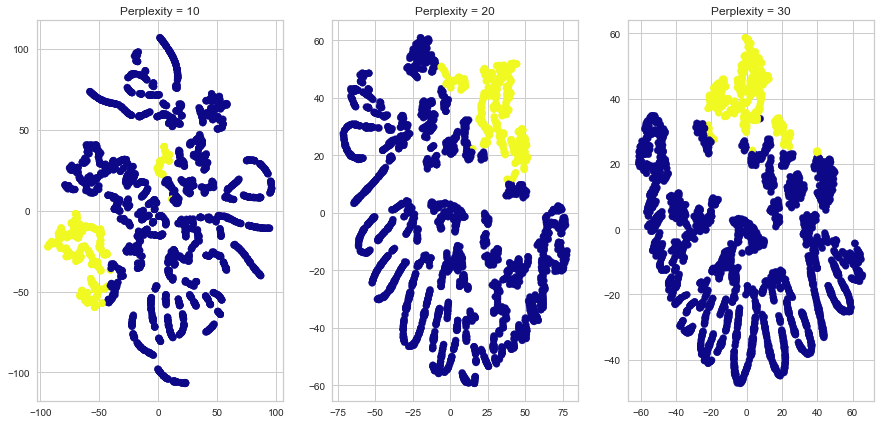

In [24]:
Tsne(df_ac,clusters_ac) #TSNE on AC model

In [25]:
#looks like KMEANS and AC isn't great when you have some categorical variables, we require a high perplexity
#score in order to have distinct features, this is not great


#lets try random tree classifier
#we will train a AC model on a portion of the data, and then use Random Forest Classiffier to insert
#more data points into the system and see if we can generate more distinct clusters...

In [26]:
from sklearn.base import BaseEstimator, clone
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.utils.metaestimators import if_delegate_has_method

#from 
# Authors: Chirag Nagpal
#          Christos Aridas

class InductiveClusterer(BaseEstimator):
    def __init__(self, clusterer, classifier):
        self.clusterer = clusterer
        self.classifier = classifier

    def fit(self, X, y=None):
        self.clusterer_ = clone(self.clusterer)
        self.classifier_ = clone(self.classifier)
        y = self.clusterer_.fit_predict(X)
        self.classifier_.fit(X, y)
        return self

    @if_delegate_has_method(delegate='classifier_')
    def predict(self, X):
        return self.classifier_.predict(X)

    @if_delegate_has_method(delegate='classifier_')
    def decision_function(self, X):
        return self.classifier_.decision_function(X)

In [37]:
# Train a clustering algorithm on the training data and get the cluster labels
df = cleaned_df()
sample_pca, sample = Sample_PCA(100000,2) 
clusterer = KMeans(n_clusters=2)

# Declare the inductive learning model that it will be used to
# predict cluster membership for unknown instances
classifier = RFC()
inductive_learner = InductiveClusterer(clusterer, classifier).fit(sample_pca)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [63]:
sample_pca, sample = Sample_PCA(250000,2) 
probable_clusters = inductive_learner.predict(sample_pca)

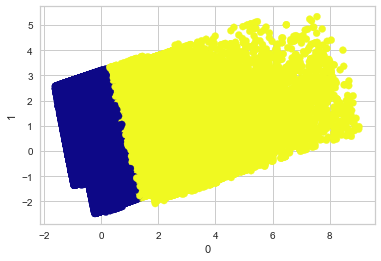

In [48]:
plot_(sample_pca, probable_clusters)

In [51]:
#this one is computationally heavy esp if you have a large sample in Sample_PCA
Tsne(sample_pca,probable_clusters)

In [ ]:
#looks like we have a small dense cluster and a second larger, less dense cluster 

In [58]:
#lets take a look at what makes our clusters different: 

sample['cluster'] = probable_clusters

In [61]:
c1 = sample[sample['cluster']==0]
c1.describe()

,trip_duration_sec,user_type,member_gender,member_age,cluster
count,424858.000000,4.248580e+05,424858.000000,424858.000000,424858.0
mean,-0.216037,3.562747e-01,0.039555,0.010770,0.0
std,0.572064,4.307115e-13,0.977103,0.999072,0.0
min,-1.129312,3.562747e-01,-1.694980,-1.701850,0.0
25%,-0.656748,3.562747e-01,0.589978,-0.743491,0.0
50%,-0.332440,3.562747e-01,0.589978,-0.211070,0.0
75%,0.116033,3.562747e-01,0.589978,0.534319,0.0
max,1.898802,3.562747e-01,0.589978,3.196426,0.0


In [62]:
c2 = sample[sample['cluster']==1]
c2.describe()

,trip_duration_sec,user_type,member_gender,member_age,cluster
count,75142.000000,75142.000000,75142.000000,75142.000000,75142.0
mean,1.219577,-2.010471,-0.217521,-0.053423,1.0
std,1.748508,1.372876,1.092274,1.009353,0.0
min,-1.129312,-2.806823,-1.694980,-1.701850,1.0
25%,-0.097084,-2.806823,-1.694980,-0.743491,1.0
50%,0.814685,-2.806823,0.589978,-0.317554,1.0
75%,2.056323,0.356275,0.589978,0.427835,1.0
max,9.689616,0.356275,0.589978,3.196426,1.0


In [ ]:
#First cluster of customers are categorised as having:
#1.much shorter trips
#2.not being subscribers
#3.slightly more male dominante 
#4.slightly older

#cluster 2 also has much more deviation in all categories compare to cluster 1. 
#aka cluster 1 data is much more compact and clear.